# Try using `climpred` to recreate some results from the CanESM5 decadal prediction paper

In [1]:
import cftime

import numpy as np
import xarray as xr

from src import plot
import matplotlib.pyplot as plt

import climpred
from climpred import HindcastEnsemble

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [3]:
xr.set_options(keep_attrs=True)

## Load some data to process

In [6]:
DATA_DIR = "../../data/processed/"

hcst_dataset = "CAFEf6"
hist_dataset = "CAFE_hist"
obsv_dataset = "HadISST"

identifier = "annual.anom_1991-2020"
variable = "sst"

In [7]:
hcst = xr.open_zarr(f"{DATA_DIR}/{hcst_dataset}.{identifier}.{variable}.zarr")
hist = xr.open_zarr(f"{DATA_DIR}/{hist_dataset}.{identifier}.{variable}.zarr")
obsv = xr.open_zarr(f"{DATA_DIR}/{obsv_dataset}.{identifier}.{variable}.zarr")

hcst = hcst.drop("time")
hcst.lead.attrs["units"] = "months"  # delete

In [8]:
hcst_full = xr.open_zarr(f"{DATA_DIR}/{hcst_dataset}.annual.full.{variable}.zarr")
hist_full = xr.open_zarr(f"{DATA_DIR}/{hist_dataset}.annual.full.{variable}.zarr")
obsv_full = xr.open_zarr(f"{DATA_DIR}/{obsv_dataset}.annual.full.{variable}.zarr")

hcst_full = hcst_full.drop("time")
hcst_full.lead.attrs["units"] = "months"  # delete

In [9]:
def global_mean(ds):
    return ds.weighted(ds["area"]).mean(["lon", "lat"]).compute()

In [10]:
hcst_gbl = global_mean(hcst)
hist_gbl = global_mean(hist)
obsv_gbl = global_mean(obsv)

In [11]:
hcst_full_gbl = global_mean(hcst_full)
hist_full_gbl = global_mean(hist_full)
obsv_full_gbl = global_mean(obsv_full)

## How does climpred bias correction compare to anomalisation?

In [12]:
hindcast = HindcastEnsemble(hcst)
hindcast = hindcast.add_observations(obsv)
hindcast = hindcast.add_uninitialized(hist.chunk({"time": -1}))  # can delete

hindcast_gbl = HindcastEnsemble(hcst_gbl)
hindcast_gbl = hindcast_gbl.add_observations(obsv_gbl)
hindcast_gbl = hindcast_gbl.add_uninitialized(hist_gbl)

/g/data/xv83/users/ds0092/software/miniconda3/envs/forecast_analysis/lib/python3.9/site-packages/xarray/coding/times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/g/data/xv83/users/ds0092/software/miniconda3/envs/forecast_analysis/lib/python3.9/site-packages/xarray/coding/times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/g/data/xv83/users/ds0092/software/miniconda3/envs/forecast_analysis/lib/python3.9/site-packages/xarray/coding/times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/g/data/xv83/users/ds0092/software/miniconda3/envs/forecast_analysis/lib/python3.9/site-packages/xarray/coding/times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future versi

In [13]:
hindcast_full_gbl = HindcastEnsemble(hcst_full_gbl)
hindcast_full_gbl = hindcast_full_gbl.add_observations(obsv_full_gbl)
hindcast_full_gbl = hindcast_full_gbl.add_uninitialized(hist_full_gbl)

hindcast_cpbc_gbl = hindcast_full_gbl.remove_bias(
    alignment="same_verifs", how="additive_mean"
)

/g/data/xv83/users/ds0092/software/miniconda3/envs/forecast_analysis/lib/python3.9/site-packages/xarray/coding/times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/g/data/xv83/users/ds0092/software/miniconda3/envs/forecast_analysis/lib/python3.9/site-packages/xarray/coding/times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]


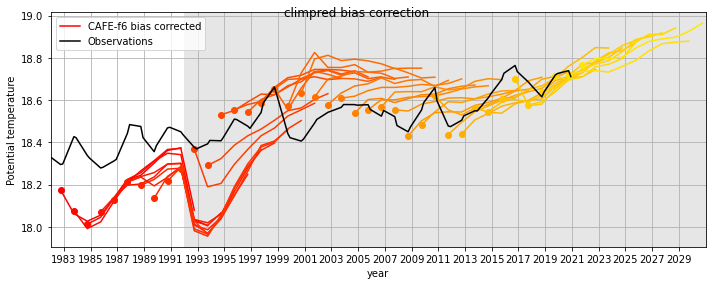

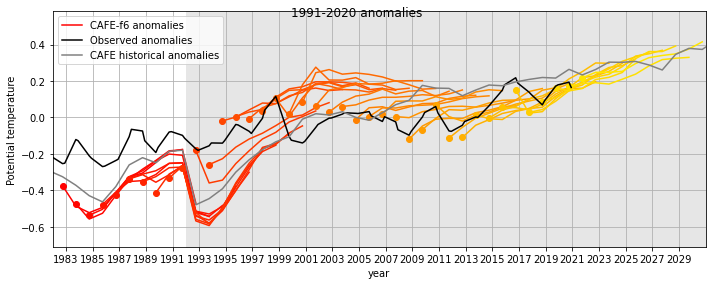

In [14]:
fig = plot.hindcasts(
    {"CAFE-f6 bias corrected": hindcast_cpbc_gbl.get_initialized().mean("member")},
    {"Observations": hindcast_cpbc_gbl.get_observations()},
    shade=True,
)
fig.suptitle("climpred bias correction")

fig = plot.hindcasts(
    {"CAFE-f6 anomalies": hindcast_gbl.get_initialized().mean("member")},
    {"Observed anomalies": hindcast_gbl.get_observations()},
    {"CAFE historical anomalies": hindcast_gbl.get_uninitialized().mean("member")},
    shade=True,
)
_ = fig.suptitle("1991-2020 anomalies")

## Compute a skill score

In [15]:
import logging

logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [16]:
acc = hindcast.verify(
    reference="uninitialized",
    metric="pearson_r",
    comparison="e2o",
    alignment="same_verifs",
    dim=["init"],
)

INFO:root:initialized | lead: 11 | inits: 1990-11-01 00:00:00-2019-11-01 00:00:00 | verifs: 1991-10-01 00:00:00-2020-10-01 00:00:00
INFO:root:initialized | lead: 23 | inits: 1989-11-01 00:00:00-2018-11-01 00:00:00 | verifs: 1991-10-01 00:00:00-2020-10-01 00:00:00
INFO:root:initialized | lead: 35 | inits: 1988-11-01 00:00:00-2017-11-01 00:00:00 | verifs: 1991-10-01 00:00:00-2020-10-01 00:00:00
INFO:root:initialized | lead: 47 | inits: 1987-11-01 00:00:00-2016-11-01 00:00:00 | verifs: 1991-10-01 00:00:00-2020-10-01 00:00:00
INFO:root:initialized | lead: 59 | inits: 1986-11-01 00:00:00-2015-11-01 00:00:00 | verifs: 1991-10-01 00:00:00-2020-10-01 00:00:00
INFO:root:initialized | lead: 71 | inits: 1985-11-01 00:00:00-2014-11-01 00:00:00 | verifs: 1991-10-01 00:00:00-2020-10-01 00:00:00
INFO:root:initialized | lead: 83 | inits: 1984-11-01 00:00:00-2013-11-01 00:00:00 | verifs: 1991-10-01 00:00:00-2020-10-01 00:00:00
INFO:root:initialized | lead: 95 | inits: 1983-11-01 00:00:00-2012-11-01 00:

In [17]:
test = hindcast.bootstrap(
    metric="pearson_r",
    comparison="e2o",
    alignment="same_verifs",
    iterations=2,
)

/g/data/xv83/users/ds0092/software/miniconda3/envs/forecast_analysis/lib/python3.9/site-packages/climpred/checks.py:236: UserWarning: Chunking might not bring parallelized performance increase, because input size quite small, found 0.10170745849609375 MB < 5 MB.
  warnings.warn(


ValueError: Dimension `'__loopdim1__'` with different lengths in arrays

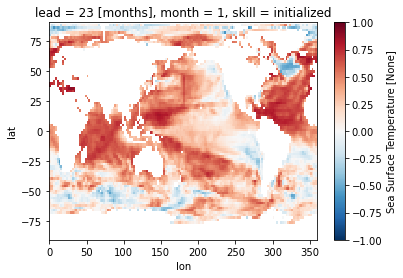

In [70]:
acc["sst"].sel(skill="initialized").isel(lead=1).plot(vmin=-1, vmax=1, cmap="RdBu_r")